In [1]:
# 2018-2022년 전국 아파트 실거래 정보

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import openpyxl
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler, FunctionTransformer
from scipy.stats import boxcox
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from haversine import haversine, Unit

In [2]:
df1 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/complex_20230308 (사본).csv', header=None)
df1.columns = ['old_addr_idx', 'complex_name', 'property_type','시도', '시군구',
               '읍면동','리','road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub','updated']
df1.drop(['road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub', 'updated'], axis=1, inplace=True)

df1['시군구'] = df1['시군구'].str.split().str[0]
df1 = df1[df1['property_type']!='officetel']
df1.drop(['property_type'], axis=1, inplace=True)

In [3]:
df1

,old_addr_idx,complex_name,시도,시군구,읍면동,리
0,1111010100_00001_00000_apartment,청운벽산빌리지,서울특별시,종로구,청운동,NaN
1,1111010100_00003_00000_apartment,인텔빌라B C동,서울특별시,종로구,청운동,NaN
2,1111010100_00003_00150_apartment,인텔빌라A동,서울특별시,종로구,청운동,NaN
3,1111010100_00004_00001_apartment,아델하우스,서울특별시,종로구,청운동,NaN
4,1111010100_00004_00003_apartment,GRACETUSCANII,서울특별시,종로구,청운동,NaN
...,...,...,...,...,...,...
320920,5013032022_00048_00003_apartment,표선제이파크빌,제주특별자치도,서귀포시,표선면,하천리
320921,5013032022_02167_00000_apartment,지오화이트빌리지,제주특별자치도,서귀포시,표선면,하천리
320922,5013032023_02008_00000_apartment,보네르펜션,제주특별자치도,서귀포시,표선면,성읍리
320923,5013032024_02521_00005_apartment,(2521-5),제주특별자치도,서귀포시,표선면,가시리


In [4]:
df2 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/property_20230308.csv', header=None)
df2.columns = ['pk','old_addr_idx','dong','ho','official_price','net_leasable_area','updated']

In [5]:
app_apt = df2.merge(df1, on='old_addr_idx')
pd.options.display.max_columns = None
app_apt['평수'] = app_apt['net_leasable_area'] / 3.3
app_apt.drop(['net_leasable_area'], axis=1, inplace=True)
app_apt.replace('\\N', np.nan, inplace=True)
app_apt['시군구'] = app_apt['시군구'].fillna('세종특별자치시')

In [6]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636
...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394


In [7]:
sido_list = app_apt['시도'].unique().tolist()
sido_list

['서울특별시',
 '부산광역시',
 '인천광역시',
 '경기도',
 '강원도',
 '충청북도',
 '세종특별자치시',
 '대전광역시',
 '충청남도',
 '전라북도',
 '광주광역시',
 '전라남도',
 '대구광역시',
 '경상북도',
 '경상남도',
 '울산광역시',
 '제주특별자치도']

In [8]:
app_apt['호']=app_apt['ho'].astype(str)

In [9]:
app_apt['호int'] = app_apt['호'].apply(lambda x: int(x) if x.isnumeric() else 0)

In [10]:
app_apt['호str'] = app_apt['호'].apply(lambda x: np.nan if x.isnumeric() else 0 if x.isdigit() else x)

In [11]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788,101,101,NaN
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970,102,102,NaN
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970,201,201,NaN
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788,202,202,NaN
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636,301,301,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,404,404,NaN
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303,502,502,NaN
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,504,504,NaN
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,501,501,NaN


In [12]:
start = 100
step = 100
num_steps = 83
ranges1 = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]
labels1 = [r[2] for r in ranges1]
bins1 = [r[0] for r in ranges1] + [ranges1[-1][1]]

bins = bins1
labels = labels1

app_apt['층'] = pd.cut(app_apt['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

In [13]:
floorSplit = app_apt[app_apt['호str'].str.contains('층')==True]

In [14]:
floorSplit['호str'] = floorSplit['호str'].str.split('층').str[0]

<ipython-input-14-5380e5940272>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['호str'] = floorSplit['호str'].str.split('층').str[0]


In [15]:
floorSplit['호int'] = floorSplit['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

<ipython-input-15-fe789eedf5cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['호int'] = floorSplit['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)


In [16]:
start = 100
step = 100
num_steps = 16
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

floorSplit['층'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-16-9318b6f1daca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['층'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)


In [17]:
start1 = 1
step1 = 1
num_steps1 = 90
ranges2 = [(start1 + step1 * i, start1 + step1 * i + 0.1, i+1) for i in range(num_steps1)]
labels2 = [r[2] for r in ranges2]
bins2 = [r[0] for r in ranges2] + [ranges2[-1][1]]

# concatenate the two lists of bin edges and labels
bins = bins2
labels = labels2
# convert the '호int' column to a categorical column
floorSplit['층2'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-17-1196a492ffd3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['층2'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)


In [18]:
codes = floorSplit['층'].cat.codes
codes2 = floorSplit['층2'].cat.codes
floorSplit['codes'] = codes.reindex(floorSplit.index)
floorSplit['codes2'] = codes2.reindex(floorSplit.index)
floorSplit['codes'].replace(-1, np.nan, inplace=True)
floorSplit['codes2'].replace(-1, np.nan, inplace=True)
floorSplit['codes'] = floorSplit['codes'] + 1
floorSplit['codes2'] = floorSplit['codes2'] + 1
floorSplit['codes'] = floorSplit['codes'].fillna(floorSplit['codes2'])
floorSplit.drop(['층', '층2', 'codes2'], axis=1, inplace=True)

<ipython-input-18-493d9e1025b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['codes'] = codes.reindex(floorSplit.index)
<ipython-input-18-493d9e1025b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['codes2'] = codes2.reindex(floorSplit.index)
<ipython-input-18-493d9e1025b8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [19]:
check = floorSplit[floorSplit['codes'].isnull()==True]

In [20]:
jiha = check[check['호str'].str.contains('지하')==True]
jiha['codes'] = -1
jiha = jiha[['pk', 'codes']]
check = check.merge(jiha, on=['pk'], how='left')
check = check.drop('codes_x', axis=1)
check = check.rename(columns={'codes_y':'codes'})

jisang = check[check['호str'].str.contains('지상')]
jisang['호str'] = jisang['호str'].str.split('지상').str[1]
jisang['codes'] = jisang['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

mask = (jisang['pk']=='11999085_0001_0001')
jisang.loc[mask, 'codes']=1
mask = (jisang['pk']=='12148950_0001_0002')
jisang.loc[mask, 'codes']=2
mask = (jisang['pk']=='12148950_0001_0004')
jisang.loc[mask, 'codes']=3
mask = (jisang['pk']=='12148950_0001_0005')
jisang.loc[mask, 'codes']=3
mask = (jisang['pk']=='12148950_0001_0006')
jisang.loc[mask, 'codes']=4

jisang = jisang[['pk', 'codes']]

check = check.merge(jisang, on=['pk'], how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

justJi = check[check['호str'].str.contains('지')&~(check['호str'].str.contains('지하'))&~(check['호str'].str.contains('지상'))]
justJi['codes'] = -1

justJi = justJi[['pk', 'codes']]

check = check.merge(justJi, on=['pk'], how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

<ipython-input-20-4e921100afe9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiha['codes'] = -1
<ipython-input-20-4e921100afe9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang['호str'] = jisang['호str'].str.split('지상').str[1]
<ipython-input-20-4e921100afe9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [21]:
dong = check[(check['호str'].str.contains('동')==True) & (check['호str'].str.contains('지')!=True)]
dong['호str'] = dong['호str'].str.split('동').str[1]

mask = (dong['호str'].str.contains('3'))
dong.loc[mask, 'codes'] = 3
mask = (dong['호str'].str.contains('4'))
dong.loc[mask, 'codes'] = 4
mask = (dong['호str'].str.contains('일'))
dong.loc[mask, 'codes'] = 1
mask = (dong['호str'].str.contains('이'))
dong.loc[mask, 'codes'] = 2
mask = (dong['호str'].str.contains('삼'))
dong.loc[mask, 'codes'] = 3
mask = (dong['호str'].str.contains('사'))
dong.loc[mask, 'codes'] = 4
mask = (dong['호str'].str.contains('5'))
dong.loc[mask, 'codes'] = 5

mask = (dong['호str'].str.contains('1')) & (~dong['호str'].str.contains('2'))
dong.loc[mask, 'codes'] = 1
mask = (dong['호str'].str.contains('2')) & (~dong['호str'].str.contains('1'))
dong.loc[mask, 'codes'] = 2

mask = (dong['호str']=='10')
dong.loc[mask, 'codes'] = 10
mask = (dong['호str']=='11')
dong.loc[mask, 'codes'] = 11
mask = (dong['호str']=='12')
dong.loc[mask, 'codes'] = 12
mask = (dong['호str']=='13')
dong.loc[mask, 'codes'] = 13
mask = (dong['호str']=='14')
dong.loc[mask, 'codes'] = 14
mask = (dong['호str']=='15')
dong.loc[mask, 'codes'] = 15

mask = (dong['호str']=='2호1')
dong.loc[mask, 'codes'] = 1
mask = (dong['호str']=='1호2')
dong.loc[mask, 'codes'] = 2

dong = dong[['pk', 'codes']]

check = check.merge(dong, on='pk', how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

<ipython-input-21-9432fbcc790e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong['호str'] = dong['호str'].str.split('동').str[1]


In [22]:
rest = check[check['codes'].isnull()==True]

regex = r'\D+(\d+)$'
rest['codes'] = rest['호str'].str.extract(regex)

rest_of_rest = rest[rest['codes'].isnull()==True]

mask = (rest_of_rest['호str'].str.contains('일'))
rest_of_rest.loc[mask, 'codes'] = 1
mask = (rest_of_rest['호str'].str.contains('이'))
rest_of_rest.loc[mask, 'codes'] = 2
mask = (rest_of_rest['호str'].str.contains('사'))
rest_of_rest.loc[mask, 'codes'] = 4
mask = (rest_of_rest['호str'].str.contains('삼'))
rest_of_rest.loc[mask, 'codes'] = 3
mask = (rest_of_rest['호str'].str.contains('오'))
rest_of_rest.loc[mask, 'codes'] = 5
mask = (rest_of_rest['호str'].str.contains('육'))
rest_of_rest.loc[mask, 'codes'] = 6
mask = (rest_of_rest['호str'].str.contains('칠'))
rest_of_rest.loc[mask, 'codes'] = 7

rest_of_rest_bok = rest_of_rest[rest_of_rest['codes'].isnull()==True]
rest_of_rest_bok = rest_of_rest[rest_of_rest['호str'].str.contains('복')]
rest_of_rest_bok['호str']= rest_of_rest_bok['호str'].str.split('복').str[0]

rest_of_rest_bok['numeric'] = rest_of_rest_bok['호str'].str.extract('(\d+)')
rest_of_rest_bok['numeric'] = rest_of_rest_bok['numeric'].fillna(0)
rest_of_rest_bok['numeric'] = rest_of_rest_bok['numeric'].astype(int)

start = 100
step = 100
num_steps = 16
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

rest_of_rest_bok['층'] = pd.cut(rest_of_rest_bok['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)



<ipython-input-22-3e2152d64c0e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest['codes'] = rest['호str'].str.extract(regex)
<ipython-input-22-3e2152d64c0e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['호str']= rest_of_rest_bok['호str'].str.split('복').str[0]
<ipython-input-22-3e2152d64c0e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [23]:
codes3 = rest_of_rest_bok['층'].cat.codes
rest_of_rest_bok['codes3'] = codes3.reindex(rest_of_rest_bok.index)
rest_of_rest_bok['codes3'].replace(-1, np.nan, inplace=True)
rest_of_rest_bok['codes3'] = rest_of_rest_bok['codes3'] + 1
rest_of_rest_bok.drop(['codes', 'numeric', '층'], axis=1, inplace=True)
rest_of_rest_bok = rest_of_rest_bok.rename(columns={'codes3':'codes'})
rest_of_rest_bok = rest_of_rest_bok[['pk', 'codes']]

rest_of_rest = rest_of_rest.merge(rest_of_rest_bok, on='pk', how='left')
rest_of_rest['codes_x'] = rest_of_rest['codes_x'].fillna(rest_of_rest['codes_y'])
rest_of_rest = rest_of_rest.rename(columns={'codes_x':'codes'})
rest_of_rest.drop('codes_y', axis=1, inplace=True)

mask = (rest_of_rest['codes']==0)
rest_of_rest.loc[mask, 'codes'] = 3

<ipython-input-23-1b9d5dade8fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['codes3'] = codes3.reindex(rest_of_rest_bok.index)
<ipython-input-23-1b9d5dade8fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['codes3'].replace(-1, np.nan, inplace=True)
<ipython-input-23-1b9d5dade8fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [24]:
rest_of_rest_ = rest_of_rest[rest_of_rest['codes'].isnull()==True]

mask = (rest_of_rest_['ho'].str.contains('별층'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('비층'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('B'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('401'))
rest_of_rest_.loc[mask, 'codes'] = 4
mask = (rest_of_rest_['ho'].str.contains('402'))
rest_of_rest_.loc[mask, 'codes'] = 4
mask = (rest_of_rest_['ho'].str.contains('201'))
rest_of_rest_.loc[mask, 'codes'] = 2
mask = (rest_of_rest_['ho'].str.contains('202'))
rest_of_rest_.loc[mask, 'codes'] = 2

mask = (rest_of_rest_['pk']=='12085035_0001_0004')
rest_of_rest_.loc[mask, 'codes'] = 4

rest_of_rest_ = rest_of_rest_[['pk', 'codes']]

rest_of_rest = rest_of_rest.merge(rest_of_rest_, on='pk', how='left')
rest_of_rest['codes_x'] = rest_of_rest['codes_x'].fillna(rest_of_rest['codes_y'])
rest_of_rest = rest_of_rest.rename(columns={'codes_x':'codes'})
rest_of_rest.drop('codes_y', axis=1, inplace=True)

rest_of_rest = rest_of_rest[['pk', 'codes']]
rest = rest.merge(rest_of_rest, on='pk', how='left')
rest['codes_x'] = rest['codes_x'].fillna(rest['codes_y'])
rest = rest.rename(columns={'codes_x':'codes'})
rest.drop('codes_y', axis=1, inplace=True)

rest = rest[['pk', 'codes']]
check = check.merge(rest, on='pk', how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

check = check[['pk', 'codes']]
floorSplit = floorSplit.merge(check, on='pk', how='left')
floorSplit['codes_x'] = floorSplit['codes_x'].fillna(floorSplit['codes_y'])
floorSplit = floorSplit.rename(columns={'codes_x':'codes'})
floorSplit.drop('codes_y', axis=1, inplace=True)

mask = (floorSplit['pk']=='12030365_0001_0005')
floorSplit.loc[mask, 'codes'] = 3
mask = (floorSplit['pk']=='12035834_0001_0003')
floorSplit.loc[mask, 'codes'] = 3

In [25]:
codes4 = app_apt['층'].cat.codes
app_apt['codes'] = codes4.reindex(app_apt.index)
app_apt['codes'] = app_apt['codes'] + 1
app_apt['codes'].replace(0, np.nan, inplace=True)

floorSplit = floorSplit[['pk', 'codes']]
app_apt = app_apt.merge(floorSplit, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [26]:
last = app_apt[app_apt['codes'].isnull()==True]
last.drop(['호int', '호str', '층'], axis=1, inplace=True)

<ipython-input-26-a88709004904>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last.drop(['호int', '호str', '층'], axis=1, inplace=True)


In [27]:
last['codes'].info()

<class 'pandas.core.series.Series'>
Int64Index: 230837 entries, 6 to 14495298
Series name: codes
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 3.5+ MB


In [28]:
jiha2 = last[last['호'].str.contains('지하')==True]
jiha2['codes'] = -1
jiha2 = jiha2[['pk', 'codes']]
last = last.merge(jiha2, on=['pk'], how='left')
last = last.drop('codes_x', axis=1)
last = last.rename(columns={'codes_y':'codes'})

<ipython-input-28-c4a92d2f4a90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiha2['codes'] = -1


In [29]:
jisang2 = last[last['호'].str.contains('지상')]
jisang2['호'] = jisang2['호'].str.split('지상').str[1]

<ipython-input-29-25076aa31f93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['호'] = jisang2['호'].str.split('지상').str[1]


In [30]:
jisang2['numeric'] = jisang2['호'].str.extract('(\d+)')
jisang2['numeric'] = jisang2['numeric'].fillna(0)
jisang2['numeric'] = jisang2['numeric'].astype(int)

start = 100
step = 100
num_steps = 18
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

jisang2['층'] = pd.cut(jisang2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

start1 = 1
step1 = 1
num_steps1 = 90
ranges2 = [(start1 + step1 * i, start1 + step1 * i + 0.1, i+1) for i in range(num_steps1)]
labels2 = [r[2] for r in ranges2]
bins2 = [r[0] for r in ranges2] + [ranges2[-1][1]]

# concatenate the two lists of bin edges and labels
bins = bins2
labels = labels2
# convert the 'numeric' column to a categorical column
jisang2['층2'] = pd.cut(jisang2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

codes = jisang2['층'].cat.codes
codes2 = jisang2['층2'].cat.codes
jisang2['codes'] = codes.reindex(jisang2.index)
jisang2['codes2'] = codes2.reindex(jisang2.index)
jisang2['codes'].replace(-1, np.nan, inplace=True)
jisang2['codes2'].replace(-1, np.nan, inplace=True)
jisang2['codes'] = jisang2['codes'] + 1
jisang2['codes2'] = jisang2['codes2'] + 1
jisang2['codes'] = jisang2['codes'].fillna(jisang2['codes2'])
jisang2.drop(['층', '층2', 'codes2', 'numeric'], axis=1, inplace=True)

mask = (jisang2['pk']=='20031264_0001_0001')
jisang2.loc[mask, 'codes'] = 1

<ipython-input-30-4e5c74641632>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['numeric'] = jisang2['호'].str.extract('(\d+)')
<ipython-input-30-4e5c74641632>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['numeric'] = jisang2['numeric'].fillna(0)
<ipython-input-30-4e5c74641632>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [31]:
last

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,codes
0,00000001_0001_0007,1111010100_00004_00007_apartment,단일,B02,390000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,27.490909,B02,NaN
1,00000001_0001_0008,1111010100_00004_00007_apartment,단일,B01,524000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,35.990909,B01,NaN
2,00000002_0001_0001,1111010100_00003_00000_apartment,비,1,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.927273,1,NaN
3,00000002_0001_0002,1111010100_00003_00000_apartment,비,10,1391000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.745455,10,NaN
4,00000002_0001_0003,1111010100_00003_00000_apartment,비,2,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.800000,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230832,20430554_0002_0019,4146125321_00531_00005_apartment,102,B03,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B03,NaN
230833,20430554_0002_0020,4146125321_00531_00005_apartment,102,B04,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B04,NaN
230834,20431047_0001_0009,4161025322_00277_00007_apartment,101,B02,216000000,2021-10-01,T.S크라이시Ⅲ,경기도,광주시,초월읍,쌍동리,25.374242,B02,NaN
230835,20431216_0001_0001,4122025042_00088_00000_apartment,A,A,573000000,2021-06-01,WoodenBreeze,경기도,평택시,팽성읍,동창리,82.887879,A,NaN


In [32]:
jisang2 = jisang2[['pk', 'codes']]
last = last.merge(jisang2, on='pk', how='left')
last['codes_x'] = last['codes_x'].fillna(last['codes_y'])
last = last.rename(columns={'codes_x':'codes'})
last.drop('codes_y', axis=1, inplace=True)

In [33]:
last['codes'].info()

<class 'pandas.core.series.Series'>
Int64Index: 230837 entries, 0 to 230836
Series name: codes
Non-Null Count  Dtype  
--------------  -----  
9511 non-null   float64
dtypes: float64(1)
memory usage: 3.5 MB


In [34]:
last = last[['pk', 'codes']]
last = last.dropna(subset='codes')
app_apt = app_apt.merge(last, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [35]:
app_apt_match = app_apt[['old_addr_idx', 'official_price', '시도', '시군구', '읍면동', '리', '평수', 'codes']]

In [38]:
###########################################                                         ###################################
##############################################    공시지가 층수 작업 미완료 !!!    #############################################
###########################################       공시지가 층수 작업 미완료 !!!      #######################################
#########################################                                           ###############################################

pd.set_option('display.max_rows', 10)

In [36]:
last2 = app_apt[app_apt['codes'].isnull()==True]

In [37]:
last2['numeric'] = last2['호'].str.extract('(\d+)')
last2['numeric'] = last2['numeric'].fillna(0)
last2['numeric'] = last2['numeric'].astype(int)

start = 100
step = 100
num_steps = 50
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

last2['층'] = pd.cut(last2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-37-7494bad5c2f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['numeric'] = last2['호'].str.extract('(\d+)')
<ipython-input-37-7494bad5c2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['numeric'] = last2['numeric'].fillna(0)
<ipython-input-37-7494bad5c2f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [38]:
mask = (last2['numeric']==0)
last2.loc[mask, 'numeric'] = 1

In [39]:
mask = (last2['호'].str.contains('B0'))
last2.loc[mask, 'numeric'] = -1

In [40]:
codes5 = last2['층'].cat.codes
last2['codes2'] = codes.reindex(last2.index)
last2['codes2'].replace(-1, np.nan, inplace=True)
last2['codes2'] = last2['codes2'] + 1
last2['codes'] = last2['codes'].fillna(last2['codes2'])
last2['codes'] = last2['codes'].fillna(last2['numeric'])
last2.drop(['층','codes2', 'numeric'], axis=1, inplace=True)

<ipython-input-40-924028124f2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['codes2'] = codes.reindex(last2.index)
<ipython-input-40-924028124f2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['codes2'].replace(-1, np.nan, inplace=True)
<ipython-input-40-924028124f2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [41]:
last2

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str,codes
6,00000001_0001_0007,1111010100_00004_00007_apartment,단일,B02,390000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,27.490909,B02,0,B02,-1.0
7,00000001_0001_0008,1111010100_00004_00007_apartment,단일,B01,524000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,35.990909,B01,0,B01,-1.0
8,00000002_0001_0001,1111010100_00003_00000_apartment,비,1,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.927273,1,1,NaN,1.0
9,00000002_0001_0002,1111010100_00003_00000_apartment,비,10,1391000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.745455,10,10,NaN,10.0
10,00000002_0001_0003,1111010100_00003_00000_apartment,비,2,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.800000,2,2,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14482716,20430554_0002_0019,4146125321_00531_00005_apartment,102,B03,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B03,0,B03,-1.0
14482717,20430554_0002_0020,4146125321_00531_00005_apartment,102,B04,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B04,0,B04,-1.0
14493054,20431047_0001_0009,4161025322_00277_00007_apartment,101,B02,216000000,2021-10-01,T.S크라이시Ⅲ,경기도,광주시,초월읍,쌍동리,25.374242,B02,0,B02,-1.0
14495297,20431216_0001_0001,4122025042_00088_00000_apartment,A,A,573000000,2021-06-01,WoodenBreeze,경기도,평택시,팽성읍,동창리,82.887879,A,0,A,1.0


In [42]:
last2 = last2[['pk', 'codes']]
app_apt = app_apt.merge(last2, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [43]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str,층,codes
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788,101,101,NaN,1,1.0
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970,102,102,NaN,1,1.0
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970,201,201,NaN,2,2.0
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788,202,202,NaN,2,2.0
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636,301,301,NaN,3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,404,404,NaN,4,4.0
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303,502,502,NaN,5,5.0
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,504,504,NaN,5,5.0
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,501,501,NaN,5,5.0


In [44]:
app_apt_match = app_apt[['old_addr_idx', 'official_price', '시도', '시군구', '읍면동', '리', '평수', 'codes']]
app_apt_match = app_apt_match.rename(columns={'codes':'층수', 'official_price':'공시지가'})
app_apt_match = app_apt_match.drop_duplicates()

In [45]:
app_apt_match

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수
0,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,63.978788,1.0
1,1111010100_00004_00007_apartment,1076000000,서울특별시,종로구,청운동,NaN,63.396970,1.0
2,1111010100_00004_00007_apartment,1140000000,서울특별시,종로구,청운동,NaN,62.996970,2.0
3,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,65.178788,2.0
4,1111010100_00004_00007_apartment,1332000000,서울특별시,종로구,청운동,NaN,66.463636,3.0
...,...,...,...,...,...,...,...,...
14496518,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,3.0
14496521,2647010200_01288_00036_apartment,43900000,부산광역시,연제구,연산동,NaN,5.630303,4.0
14496523,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,4.0
14496525,2647010200_01288_00036_apartment,43300000,부산광역시,연제구,연산동,NaN,5.630303,5.0


In [46]:
daegu = app_apt_match[app_apt_match['시도']=='대구광역시']

In [47]:
daegu

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수
3817311,2711010100_00116_00000_apartment,133000000,대구광역시,중구,동인동1가,NaN,19.242424,3.0
3817312,2711010100_00116_00000_apartment,119000000,대구광역시,중구,동인동1가,NaN,17.481818,3.0
3817313,2711010100_00116_00000_apartment,106000000,대구광역시,중구,동인동1가,NaN,15.536364,3.0
3817314,2711010100_00116_00000_apartment,135000000,대구광역시,중구,동인동1가,NaN,19.242424,3.0
3817325,2711010100_00116_00000_apartment,128000000,대구광역시,중구,동인동1가,NaN,19.242424,4.0
...,...,...,...,...,...,...,...,...
14493151,2729010200_01237_00004_apartment,317000000,대구광역시,달서구,두류동,NaN,37.002273,9.0
14494722,2714011400_00702_00017_apartment,123000000,대구광역시,동구,신평동,NaN,21.802727,2.0
14494724,2714011400_00702_00017_apartment,123000000,대구광역시,동구,신평동,NaN,21.802727,3.0
14494726,2714011400_00702_00017_apartment,123000000,대구광역시,동구,신평동,NaN,21.802727,4.0


In [48]:
areaCode = pd.read_excel('/home/subin/다운로드/행정_법정동 중심좌표_동별.xlsx')
areaCode = areaCode[areaCode['코드종류']=='B']
areaCode.drop(['코드', '코드종류'], axis=1, inplace=True)
areaCode['시군구'] = areaCode['시군구'].str.split().str[0]

In [50]:
areaCodeMain = areaCode[areaCode['시도']=='대구광역시']

In [51]:
areaCodeMain

,시도,시군구,읍면동,리,위도,경도
4260,대구광역시,중구,동인동1가,NaN,35.871874,128.603897
4261,대구광역시,중구,동인동2가,NaN,35.869570,128.604131
4262,대구광역시,중구,동인동3가,NaN,35.871487,128.609198
4263,대구광역시,중구,동인동4가,NaN,35.867841,128.609506
4264,대구광역시,중구,삼덕동1가,NaN,35.866598,128.598143
...,...,...,...,...,...,...
4545,대구광역시,달성군,구지면,화산리,35.664314,128.407590
4546,대구광역시,달성군,구지면,수리리,35.668221,128.398223
4547,대구광역시,달성군,구지면,징리,35.669902,128.381540
4548,대구광역시,달성군,구지면,오설리,35.681379,128.368486


In [52]:
daegu =daegu.merge(areaCodeMain, on=['시도', '시군구', '읍면동', '리'], how='left')

In [53]:
daegu

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수,위도,경도
0,2711010100_00116_00000_apartment,133000000,대구광역시,중구,동인동1가,NaN,19.242424,3.0,35.871874,128.603897
1,2711010100_00116_00000_apartment,119000000,대구광역시,중구,동인동1가,NaN,17.481818,3.0,35.871874,128.603897
2,2711010100_00116_00000_apartment,106000000,대구광역시,중구,동인동1가,NaN,15.536364,3.0,35.871874,128.603897
3,2711010100_00116_00000_apartment,135000000,대구광역시,중구,동인동1가,NaN,19.242424,3.0,35.871874,128.603897
4,2711010100_00116_00000_apartment,128000000,대구광역시,중구,동인동1가,NaN,19.242424,4.0,35.871874,128.603897
...,...,...,...,...,...,...,...,...,...,...
155719,2729010200_01237_00004_apartment,317000000,대구광역시,달서구,두류동,NaN,37.002273,9.0,35.856247,128.564793
155720,2714011400_00702_00017_apartment,123000000,대구광역시,동구,신평동,NaN,21.802727,2.0,35.880351,128.683824
155721,2714011400_00702_00017_apartment,123000000,대구광역시,동구,신평동,NaN,21.802727,3.0,35.880351,128.683824
155722,2714011400_00702_00017_apartment,123000000,대구광역시,동구,신평동,NaN,21.802727,4.0,35.880351,128.683824


In [54]:
code = areaCode[areaCode['시도']=='대구광역시'].groupby(['시도','시군구']).mean().reset_index()
code['읍면동'] = np.nan
daegu = code.set_index(['시도', '시군구', '읍면동']).combine_first(daegu.set_index(['시도', '시군구', '읍면동'])).reset_index()

<ipython-input-54-4f699adf35cd>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']=='대구광역시'].groupby(['시도','시군구']).mean().reset_index()


In [55]:
daegu

,시도,시군구,읍면동,old_addr_idx,경도,공시지가,리,위도,층수,평수
0,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,125000000,NaN,35.844028,1.0,25.200000
1,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,130000000,NaN,35.844028,2.0,25.200000
2,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,139000000,NaN,35.844028,3.0,25.200000
3,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,130000000,NaN,35.844028,5.0,25.200000
4,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,125000000,NaN,35.844028,6.0,25.200000
...,...,...,...,...,...,...,...,...,...,...
155719,대구광역시,중구,NaN,2711015700_00590_00488_apartment,128.592927,70000000,NaN,35.870628,-1.0,18.327273
155720,대구광역시,중구,NaN,2711015700_00735_00033_apartment,128.592927,122000000,NaN,35.870628,2.0,22.751515
155721,대구광역시,중구,NaN,2711015700_00735_00033_apartment,128.592927,122000000,NaN,35.870628,3.0,22.751515
155722,대구광역시,중구,NaN,2711015700_00735_00033_apartment,128.592927,122000000,NaN,35.870628,5.0,22.751515


In [56]:
daegu_name = daegu[['old_addr_idx', '위도', '경도']]
daegu_name = daegu_name.drop_duplicates()
daegu_name['위도+경도'] = daegu_name['위도'].astype(str) + daegu_name['경도'].astype(str)

In [57]:
daeguArea = daegu[['위도', '경도']]
daeguArea = daeguArea.drop_duplicates()
daeguArea['위도+경도'] = daeguArea['위도'].astype(str) + daeguArea['경도'].astype(str)

In [58]:
school = pd.read_excel('/home/subin/다운로드/전국초중등학교위치표준데이터-20230404.xls')
school.rename(columns=school.iloc[0], inplace=True)
school = school.drop(0)

school['시도']=school['시도교육청명'].str.split('교육청').str[0]
school.drop(['시도교육청명', '제공기관명', '생성일자', '변경일자', '교육지원청명', '데이터기준일자','소재지지번주소', '소재지도로명주소', '설립일자',
             '학교ID', '제공기관코드', '시도교육청코드', '교육지원청코드', '운영상태'], axis=1, inplace=True)
school['학교급구분'] = school['학교급구분'].str.split('학교').str[0]

school['위도'] = school['위도'].astype(float).round(6)
school['경도'] = school['경도'].astype(float).round(6)

In [60]:
school_daegu = school[school['시도']=='대구광역시']
school_daegu

,학교명,학교급구분,설립형태,본교분교구분,위도,경도,시도
10,대구하빈초등학교,초등,공립,본교,35.901637,128.442112,대구광역시
11,대구효목초등학교,초등,공립,본교,35.876004,128.641576,대구광역시
14,대구서부고등학교,고등,공립,본교,35.873653,128.560201,대구광역시
18,대구대청초등학교,초등,공립,본교,35.850906,128.650167,대구광역시
36,심인중학교,중,사립,본교,35.853089,128.467898,대구광역시
...,...,...,...,...,...,...,...
11942,대구아양초등학교,초등,공립,본교,35.887463,128.637434,대구광역시
11944,동원중학교,중,공립,본교,35.875856,128.651071,대구광역시
11947,대구남산고등학교,고등,사립,본교,35.857312,128.609179,대구광역시
11981,대구국우초등학교,초등,공립,본교,35.955792,128.585695,대구광역시


In [61]:
school_ele = school_daegu[school_daegu['학교급구분']=='초등']
school_mid = school_daegu[school_daegu['학교급구분']=='중']
school_high = school_daegu[school_daegu['학교급구분']=='고등']

In [62]:
school_daeguArea= school_daegu.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_eleArea = school_ele.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_midArea = school_mid.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_highArea = school_high.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)

In [63]:
daegu_subway = pd.read_excel('/home/subin/다운로드/대구도시철도공사 역위치.xlsx')
daegu_subway = daegu_subway.rename(columns={'선명': '노선명', '역명': '역사명'})
daegu_subway.drop('철도운영기관명', axis=1, inplace=True)
daegu_subway

# https://data.kric.go.kr/rips/M_01_01/detail.do;jsessionid=7wdn4BXs4uMpBfKePMt7VWqq?id=213&sortOrder=DESC&page=4&sort=numberOfApplications

,노선명,역사명,경도,위도
0,1호선,설화명곡,128.489393,35.798618
1,1호선,화원,128.500409,35.804349
2,1호선,대곡(정부대구청사),128.511170,35.809271
3,1호선,진천,128.522374,35.813815
4,1호선,월배,128.530119,35.816123
...,...,...,...,...
86,3호선,황금,128.623919,35.839078
87,3호선,수성못(TBC),128.623217,35.831356
88,3호선,지산,128.631951,35.825153
89,3호선,범물,128.640113,35.820839


In [64]:
from scipy.spatial.distance import cdist
housing_coords = daeguArea[['위도', '경도']].values
subway_coords = daegu_subway[['위도', '경도']].values
distances_matrix = cdist(housing_coords, subway_coords, metric=haversine)
distances_df = pd.DataFrame(distances_matrix, columns=daegu_subway['역사명'], index=daeguArea['위도+경도'])
distances_df = distances_df.reset_index().melt(id_vars='위도+경도', var_name='subway_id', value_name='distance')

In [65]:
distances_df.groupby(['위도+경도', 'subway_id']).min().reset_index().describe()

,distance
count,16896.000000
mean,10.427299
std,6.565437
min,0.049373
25%,5.483075
50%,9.259701
75%,14.002581
max,37.105372


In [226]:
distances_df[distances_df['distance']>300]

,위도+경도,subway_id,distance
5241,37.539498130.879157,다대포해수욕장,325.752070
5242,37.473165130.831094,다대포해수욕장,317.252351
5243,37.466737130.84582,다대포해수욕장,317.347892
5244,37.487612130.905506,다대포해수욕장,322.160062
5245,37.498006130.90858,다대포해수욕장,323.275608
...,...,...,...
213600,37.04201129.409771,송정역,316.508405
213601,37.059807129.422668,송정역,318.674049
213602,37.062279129.410564,송정역,318.050566
213608,36.897463175129.3731506375,송정역,303.632053


In [66]:
dis_df_40km = distances_df[distances_df['distance']<40]
daegu_subway_40km = daegu_name.merge(dis_df_40km, on='위도+경도')
daegu_subway_40km.drop(['위도', '경도', '위도+경도'], axis=1, inplace=True)

In [67]:
daegu_subway_1km =daegu_subway_40km[daegu_subway_40km['distance']<=1]
daegu_subway = pd.merge(daegu_name, daegu_subway_1km, how='left', on='old_addr_idx')
value_counts = daegu_subway[daegu_subway['distance']<=1]['old_addr_idx'].value_counts()
daegu['1km내sub수'] = daegu['old_addr_idx'].map(value_counts)
daegu['1km내sub수'] = daegu['1km내sub수'].fillna(0)

In [68]:
closest_subway_dis =daegu_subway_40km.groupby('old_addr_idx').min().drop('subway_id', axis=1).reset_index()
daegu = daegu.merge(closest_subway_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_sub'})

In [69]:
housing_coords = daeguArea[['위도', '경도']].values
school_coords = school_daegu[['위도', '경도']].values
distances_matrix2 = cdist(housing_coords, school_coords, metric=haversine)
distances_df2 = pd.DataFrame(distances_matrix2, columns=school_daegu['학교명'], index=daeguArea['위도+경도'])
distances_df2 = distances_df2.reset_index().melt(id_vars='위도+경도', var_name='school_id', value_name='distance')

In [70]:
dis_df2_25km = distances_df2[distances_df2['distance']<25]
#dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('인천과학예술영재학교', '인천과학예술영재고등학교')
#dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('동성고등공민학교', '동성공민고등학교')

In [71]:
dis_ele_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('초등학교')]
dis_mid_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('중학교')]
dis_high_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('고등학교')]

In [72]:
daegu_high_25km = daegu_name.merge(dis_high_25km.drop('school_id', axis=1), on='위도+경도')
closest_high_dis = daegu_high_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [73]:
daegu = daegu.merge(closest_high_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_high'})

In [74]:
daegu_mid_25km = daegu_name.merge(dis_mid_25km.drop('school_id', axis=1), on='위도+경도')
closest_mid_dis = daegu_mid_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [75]:
daegu = daegu.merge(closest_mid_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_mid'})

In [76]:
daegu_ele_25km = daegu_name.merge(dis_ele_25km.drop('school_id', axis=1), on='위도+경도')
closest_ele_dis = daegu_ele_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [77]:
daegu = daegu.merge(closest_ele_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_ele'})

In [78]:
dis_school_3km = dis_df2_25km[dis_df2_25km['distance']<3]

In [79]:
daegu_school_3km = daegu_name.merge(dis_school_3km.drop('school_id', axis=1), on='위도+경도')

In [80]:
daegu_school_1km =daegu_school_3km[daegu_school_3km['distance']<=1]
daegu_school = pd.merge(daegu_name, daegu_school_1km, how='left', on='old_addr_idx')
value_counts2 = daegu_school[daegu_school['distance']<=1]['old_addr_idx'].value_counts()
daegu['school_1km'] = daegu['old_addr_idx'].map(value_counts2)
daegu['school_1km'] = daegu['school_1km'].fillna(0)

In [81]:
daegu.isnull().sum()

시도                   0
시군구                  0
읍면동               1188
old_addr_idx         0
경도                   0
공시지가                 0
리               141248
위도                   0
층수                   0
평수                   0
1km내sub수             0
closest_sub          0
closest_high         0
closest_mid          0
closest_ele          0
school_1km           0
dtype: int64

In [82]:
daegu['평수'] = daegu['평수'].astype(float).round(0)
daegu['층수'] = daegu['층수'].astype(int)

In [84]:
daegu

,시도,시군구,읍면동,old_addr_idx,경도,공시지가,리,위도,층수,평수,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
0,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,125000000,NaN,35.844028,1,25.0,2.0,0.585986,0.226311,1.097309,0.463387,5.0
1,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,130000000,NaN,35.844028,2,25.0,2.0,0.585986,0.226311,1.097309,0.463387,5.0
2,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,139000000,NaN,35.844028,3,25.0,2.0,0.585986,0.226311,1.097309,0.463387,5.0
3,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,130000000,NaN,35.844028,5,25.0,2.0,0.585986,0.226311,1.097309,0.463387,5.0
4,대구광역시,남구,대명동,2720010300_00058_00002_apartment,128.576232,125000000,NaN,35.844028,6,25.0,2.0,0.585986,0.226311,1.097309,0.463387,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155719,대구광역시,중구,NaN,2711015700_00590_00488_apartment,128.592927,70000000,NaN,35.870628,-1,18.0,5.0,0.108349,0.839230,0.839230,0.355252,6.0
155720,대구광역시,중구,NaN,2711015700_00735_00033_apartment,128.592927,122000000,NaN,35.870628,2,23.0,5.0,0.108349,0.839230,0.839230,0.355252,6.0
155721,대구광역시,중구,NaN,2711015700_00735_00033_apartment,128.592927,122000000,NaN,35.870628,3,23.0,5.0,0.108349,0.839230,0.839230,0.355252,6.0
155722,대구광역시,중구,NaN,2711015700_00735_00033_apartment,128.592927,122000000,NaN,35.870628,5,23.0,5.0,0.108349,0.839230,0.839230,0.355252,6.0


In [87]:
###########################################      실거래가         ############################################################

In [85]:
df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv', header=None)
df3.columns = ['old_addr_idx', '거래날짜', '거래가격', '면적', '층수', '모름', '거래방식', '모름2', '모름3', '시군구', '주소', '읍면동', 'complex_name', '모름4', '모름5', 'property_type']
df3 = df3.drop_duplicates() 
df3['평수'] = df3['면적']/3.3
df3.fillna("NONE", inplace=True)
df3 = df3[~df3['property_type'].str.contains('officetel')]
df3 = df3[['old_addr_idx', '거래가격', '평수', '층수']]
df3

<ipython-input-85-b5dea2fc0aa1>:1: DtypeWarning: Columns (5,6,8,9,10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv', header=None)


,old_addr_idx,거래가격,평수,층수
0,3023010200_00034_00000_apartment,99000000,17.890909,2
1,3023010200_00027_00007_apartment,70000000,17.048485,5
2,3023010200_00027_00007_apartment,66000000,17.048485,1
3,3023010200_00027_00007_apartment,77000000,17.048485,3
4,3023010200_00027_00007_apartment,70000000,17.048485,5
...,...,...,...,...
2203363,5011010400_01034_00001_apartment,280000000,25.436970,5
2203364,5011010400_00777_00000_apartment,580000000,12.027273,4
2203365,5013010400_02161_00000_apartment,317000000,25.704212,2
2203366,5013010500_00147_00000_apartment,214000000,12.027273,1


In [86]:
df3 = df3.drop_duplicates()
df3['평수'] = df3['평수'].astype(float).round(0)

<ipython-input-86-695803c55b6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['평수'] = df3['평수'].astype(float).round(0)


In [87]:
df3

,old_addr_idx,거래가격,평수,층수
0,3023010200_00034_00000_apartment,99000000,18.0,2
1,3023010200_00027_00007_apartment,70000000,17.0,5
2,3023010200_00027_00007_apartment,66000000,17.0,1
3,3023010200_00027_00007_apartment,77000000,17.0,3
5,3023010200_00027_00007_apartment,97500000,17.0,5
...,...,...,...,...
2203363,5011010400_01034_00001_apartment,280000000,25.0,5
2203364,5011010400_00777_00000_apartment,580000000,12.0,4
2203365,5013010400_02161_00000_apartment,317000000,26.0,2
2203366,5013010500_00147_00000_apartment,214000000,12.0,1


In [91]:
# 지하층이 있는 경우는 한 곳 밖에 없음. 
# 따라서 공시지가 층수 나눌 때 지하는 무시해도 됨. 
# (지하층은 모두 오피스텔에서 발생, 오피스텔은 주소 등 다른 결측치가 너무 많음. 뿐만 아니라 공시지가 데이터에서도 애초에 오피스텔은 제외했었음.)

In [92]:
# 실거래가 자료에서는 공시지가와 매핑할 수 있는 게 면적, 층수밖에 없으므로 우선은 이걸 최대한 맞춰보고

# 맵핑이 상당히 까다로울 것으로 예상되는 바, old_addr_idx에 따라 공시지가 평균을 내서 일괄적으로 넣어보기.

# 면적은 맞는데 층수가 틀린 경우 (아마 얘가 많지 않을까)

In [88]:
real_trainInfo = df3.merge(daegu, on=['old_addr_idx', '평수', '층수'], how='left')
real_trainInfo = real_trainInfo.dropna(subset='공시지가')

In [90]:
real_trainInfo.drop(['old_addr_idx','읍면동',  '리'], axis=1, inplace=True)

In [91]:
real_trainInfo

,거래가격,평수,층수,시도,시군구,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
216554,120000000,25.0,2,대구광역시,남구,128.576232,113000000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216555,155000000,19.0,8,대구광역시,남구,128.576232,94800000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216556,155000000,19.0,8,대구광역시,남구,128.576232,94400000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216557,290000000,18.0,4,대구광역시,남구,128.576232,170000000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216558,180000000,18.0,10,대구광역시,남구,128.576232,175000000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121971,63000000,15.0,1,대구광역시,달성군,128.442256,29500000.0,35.727200,0.0,9.008504,3.208547,0.728216,0.267233,3.0
2121972,63000000,15.0,1,대구광역시,달성군,128.442256,29500000.0,35.727200,0.0,9.008504,3.208547,0.728216,0.267233,3.0
2121973,90000000,18.0,9,대구광역시,달성군,128.442256,44800000.0,35.727200,0.0,9.008504,3.208547,0.728216,0.267233,3.0
2122585,180000000,20.0,3,대구광역시,동구,128.623382,180000000.0,35.884774,2.0,0.803616,0.847874,1.099289,0.482658,7.0


In [92]:
main_withPrice = real_trainInfo.drop(['시도', '시군구'], axis=1)
main_withoutPrice = real_trainInfo.drop(['거래가격', '시도', '시군구'], axis=1)

In [93]:
main_withPrice

,거래가격,평수,층수,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
216554,120000000,25.0,2,128.576232,113000000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216555,155000000,19.0,8,128.576232,94800000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216556,155000000,19.0,8,128.576232,94400000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216557,290000000,18.0,4,128.576232,170000000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216558,180000000,18.0,10,128.576232,175000000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2121971,63000000,15.0,1,128.442256,29500000.0,35.727200,0.0,9.008504,3.208547,0.728216,0.267233,3.0
2121972,63000000,15.0,1,128.442256,29500000.0,35.727200,0.0,9.008504,3.208547,0.728216,0.267233,3.0
2121973,90000000,18.0,9,128.442256,44800000.0,35.727200,0.0,9.008504,3.208547,0.728216,0.267233,3.0
2122585,180000000,20.0,3,128.623382,180000000.0,35.884774,2.0,0.803616,0.847874,1.099289,0.482658,7.0


In [94]:
main_withoutPrice

,평수,층수,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
216554,25.0,2,128.576232,113000000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216555,19.0,8,128.576232,94800000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216556,19.0,8,128.576232,94400000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216557,18.0,4,128.576232,170000000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
216558,18.0,10,128.576232,175000000.0,35.844028,2.0,0.585986,0.226311,1.097309,0.463387,5.0
...,...,...,...,...,...,...,...,...,...,...,...
2121971,15.0,1,128.442256,29500000.0,35.727200,0.0,9.008504,3.208547,0.728216,0.267233,3.0
2121972,15.0,1,128.442256,29500000.0,35.727200,0.0,9.008504,3.208547,0.728216,0.267233,3.0
2121973,18.0,9,128.442256,44800000.0,35.727200,0.0,9.008504,3.208547,0.728216,0.267233,3.0
2122585,20.0,3,128.623382,180000000.0,35.884774,2.0,0.803616,0.847874,1.099289,0.482658,7.0


In [241]:
X = main_withoutPrice
y = main_withPrice['거래가격']

In [242]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [243]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [244]:
train_data = x_train.join(y_train)

In [200]:
train_data

,평수,층수,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km,거래가격
298354,26.0,13,128.551403,215000000.0,35.944173,2.0,0.624338,1.260307,0.449026,0.114673,7.0,297000000
456567,18.0,14,128.579171,356000000.0,35.867962,3.0,0.326173,0.440782,0.097271,0.310378,10.0,474000000
394011,26.0,22,128.513947,296000000.0,35.813331,2.0,0.516251,0.938025,0.983973,0.206374,8.0,393000000
355618,26.0,15,128.558469,242000000.0,35.938273,3.0,0.172692,0.479695,0.471019,0.226654,13.0,333000000
263296,26.0,19,128.534847,314000000.0,35.840094,0.0,1.180651,0.867202,0.556046,0.172891,12.0,335000000
...,...,...,...,...,...,...,...,...,...,...,...,...
280057,26.0,11,128.494954,192000000.0,35.873182,0.0,2.429769,1.443808,0.413990,0.339003,5.0,223000000
345093,31.0,22,128.716707,259000000.0,35.876938,0.0,1.201966,0.363461,0.795467,0.829436,3.0,328000000
276786,18.0,17,128.483995,166000000.0,35.848884,2.0,0.650910,0.198142,1.283332,0.293076,3.0,220000000
312647,41.0,11,128.611388,406000000.0,35.852831,3.0,0.449736,0.536565,0.536565,0.137455,7.0,429000000


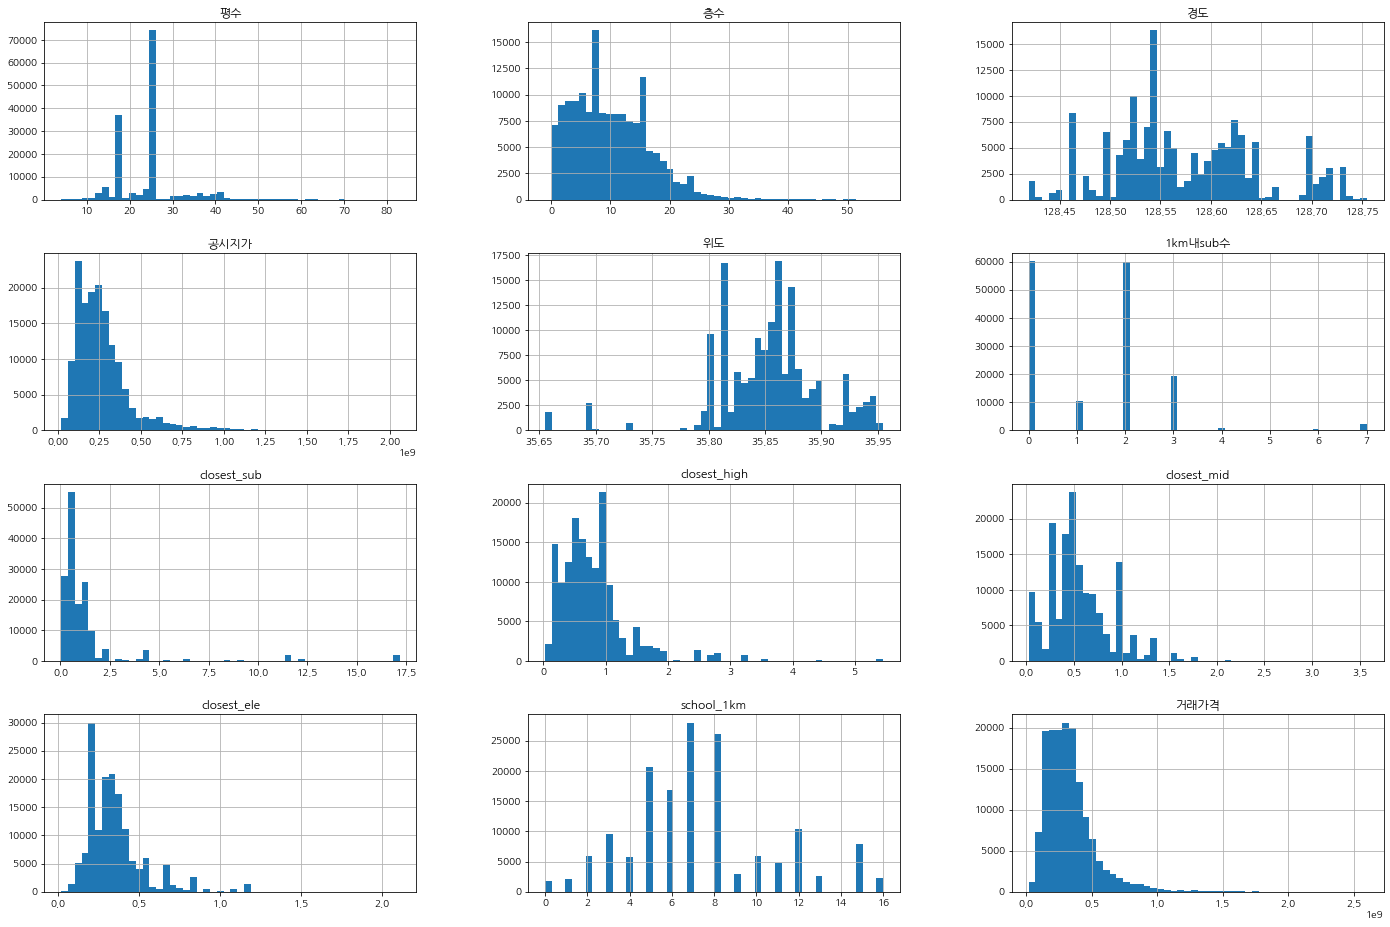

In [201]:
train_data.hist(bins=50, figsize=(24,16))
plt.rc('font', family='NanumGothic')

<Axes: >

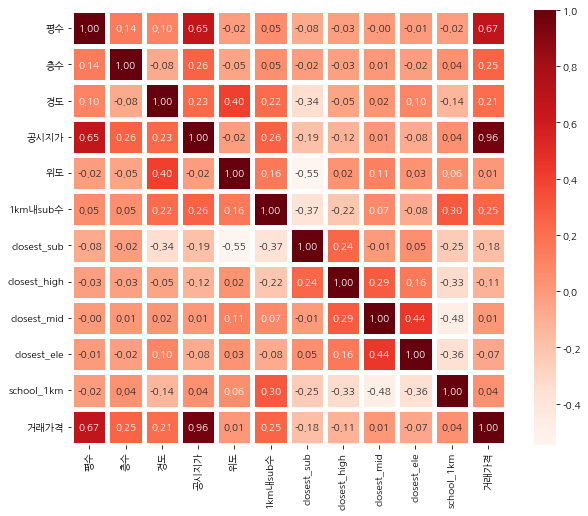

In [163]:
plt.figure(figsize=(10,8))
sns.heatmap(train_data.corr(),annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds')

In [245]:
train_data['층수+'] = train_data['층수']+2
train_data['1km내sub수+'] = train_data['1km내sub수']+2
train_data['school_1km+'] = train_data['school_1km']+2
train_data.drop(['층수', '1km내sub수', 'school_1km'], axis=1, inplace=True)

In [246]:
from scipy.stats import boxcox
train_data[['1km내sub수+', '평수']] = train_data[['1km내sub수+', '평수']].apply(lambda x: boxcox(x)[0])
train_data[['school_1km+']] = np.sqrt(train_data[['school_1km+']])
train_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(train_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

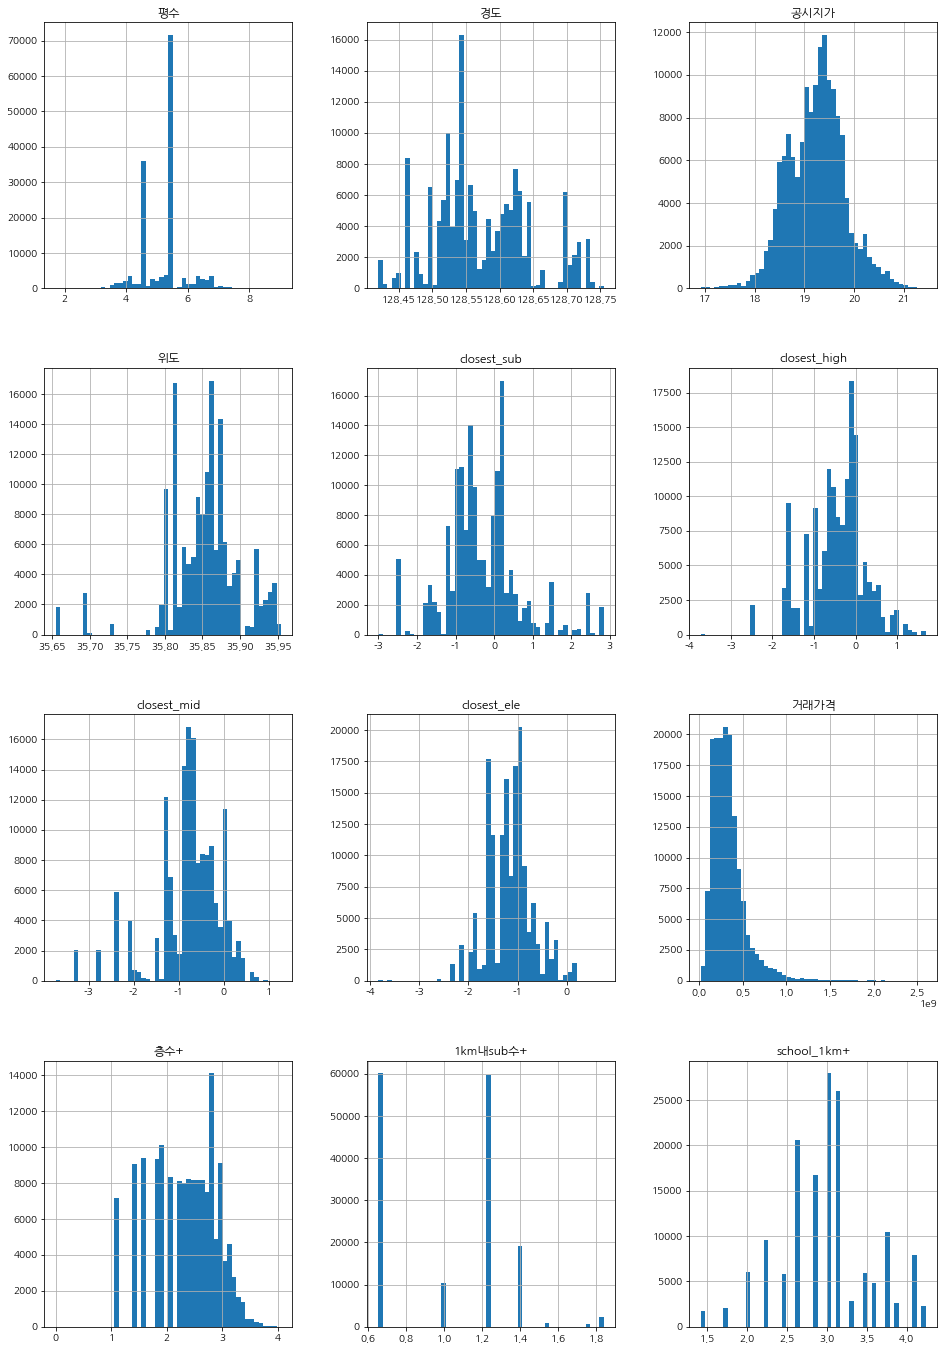

In [166]:
train_data.hist(bins=50, figsize=(16, 24))
plt.rc('font', family='NanumGothic')
plt.rc("axes", unicode_minus = False)

In [247]:
x_train, y_train = train_data.drop(['거래가격'], axis=1), train_data['거래가격']

In [248]:
valid_data = x_valid.join(y_valid)

valid_data['층수+'] = valid_data['층수']+2
valid_data['1km내sub수+'] = valid_data['1km내sub수']+2
valid_data['school_1km+'] = valid_data['school_1km']+2
valid_data.drop(['층수', '1km내sub수', 'school_1km'], axis=1, inplace=True)

from scipy.stats import boxcox
valid_data[['1km내sub수+', '평수']] = valid_data[['1km내sub수+', '평수']].apply(lambda x: boxcox(x)[0])
valid_data[['school_1km+']] = np.sqrt(valid_data[['school_1km+']])
valid_data[['거래가격', '층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(valid_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

x_valid, y_valid = valid_data.drop(['거래가격'], axis=1), valid_data['거래가격']

In [249]:
test_data = X_test.join(y_test)

test_data['층수+'] = test_data['층수']+2
test_data['1km내sub수+'] = test_data['1km내sub수']+2
test_data['school_1km+'] = test_data['school_1km']+2
test_data.drop(['층수', '1km내sub수', 'school_1km'], axis=1, inplace=True)

from scipy.stats import boxcox
test_data[['1km내sub수+', '평수']] = test_data[['1km내sub수+', '평수']].apply(lambda x: boxcox(x)[0])
test_data[['school_1km+']] = np.sqrt(test_data[['school_1km+']])
test_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(test_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

X_test, y_test = test_data.drop(['거래가격'], axis=1), test_data['거래가격']

In [250]:
scaler = MinMaxScaler()

scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_valid_s = scaler.transform(x_valid)
X_test_s = scaler.transform(X_test)

In [251]:
# 선형회귀모델
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

linear.fit(x_train_s, y_train)

linear.score(X_test_s, y_test)

0.9285018986450375

In [252]:
y_pred_li = linear.predict(x_train_s)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

lin_R2 = r2_score(y_train, y_pred_li)
lin_mae = mean_absolute_error(y_train, y_pred_li)
print(lin_R2)
print(lin_mae)
print('--------------------')
y_pred_li = linear.predict(x_valid_s)
lin_r2 = r2_score(y_valid, y_pred_li)
lin_mae = mean_absolute_error(y_valid, y_pred_li)
print(lin_R2)
print(lin_mae)

0.9282051065035557
0.10851002041504772
--------------------
0.9282051065035557
0.10905879068653372


In [253]:
# 의사결정나무

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(x_train_s, y_train)

DecisionTreeRegressor()

In [254]:
tree.score(X_test_s, y_test)

0.9056218527239795

In [255]:
y_pred_tr = tree.predict(x_train_s)

tree_R2 = r2_score(y_train, y_pred_tr)
tree_mae = mean_absolute_error(y_train, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.96937490125943
0.06308730870086858


In [256]:
y_pred_tr = tree.predict(x_valid_s)

tree_R2 = r2_score(y_valid, y_pred_tr)
tree_mae = mean_absolute_error(y_valid, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.9109346369380669
0.11205021517714026


In [257]:
# XGBoost 회귀

import xgboost

xgb_model = xgboost.XGBRegressor()
xgb_model.fit(x_train_s, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [258]:
y_pred_xgb = xgb_model.predict(x_train_s)

xgb_R2 = r2_score(y_train, y_pred_xgb)
xgb_mae = mean_absolute_error(y_train, y_pred_xgb)
print(xgb_R2)
print(xgb_mae)

0.9520382620024714
0.08708235219982079


In [259]:
y_pred_xgb = xgb_model.predict(x_valid_s)

xgb_R2 = r2_score(y_valid, y_pred_xgb)
xgb_mae = mean_absolute_error(y_valid, y_pred_xgb)
print(xgb_R2)
print(xgb_mae)

0.9434102876016661
0.09477391450651997


In [260]:
# k-fold 교차검증 선형회귀모델

def display_scores(model, scores):
    print('<<', model, '모델 평가 결과 >>')
    print('평균 RMSE: ', scores.mean())
    print('표준편차: ', scores.std())

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(linear, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores('선형회귀', lin_rmse_scores)

<< 선형회귀 모델 평가 결과 >>
평균 RMSE:  0.14612511831479422
표준편차:  0.0019160999651096744


In [261]:
# k-fold 교차검증 의사결정나무
tree_scores = cross_val_score(tree, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores('의사결정나무', tree_rmse_scores)

<< 의사결정나무 모델 평가 결과 >>
평균 RMSE:  0.15995303541176525
표준편차:  0.0017828327428438065


In [262]:
# 최종모델의 성능평가 선형회귀모델

#x_test_nor = scaler.transform(X_test)
final_pred_li = linear.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_li = mean_squared_error(y_test, final_pred_li)
final_rmse_li = np.sqrt(final_mse_li)
final_r2_li = r2_score(y_test, final_pred_li)

print('RMSE: ', final_rmse_li)
print('R2: ', final_r2_li)

RMSE:  0.14590923385919746
R2:  0.9285018986450375


In [263]:
# 최종모델의 성능평가 의사결정나무

#x_test_nor = scaler.transform(X_test)
final_pred_tree = tree.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_tree = mean_squared_error(y_test, final_pred_tree)
final_rmse_tree = np.sqrt(final_mse_tree)
final_r2_tree = r2_score(y_test, final_pred_tree)

print('RMSE: ', final_rmse_tree)
print('R2: ', final_r2_tree)

RMSE:  0.16763752729633352
R2:  0.9056218527239795


In [264]:
# 예측값과 실제값의 비교 - 시각화

pred_li = pd.DataFrame(final_pred_li, columns=['예측가격'])
actual_li = pd.DataFrame(y_test)
actual_li.reset_index(inplace=True, drop=True)
table_li = pd.concat([pred_li, actual_li], axis=1)

table_li

,예측가격,거래가격
0,19.203619,19.143387
1,19.944465,20.038087
2,20.176273,20.003775
3,19.428834,19.471502
4,19.328168,19.287781
...,...,...
47962,19.238881,19.062535
47963,18.614829,18.459901
47964,19.339800,19.209138
47965,19.521947,19.413933


<Axes: >

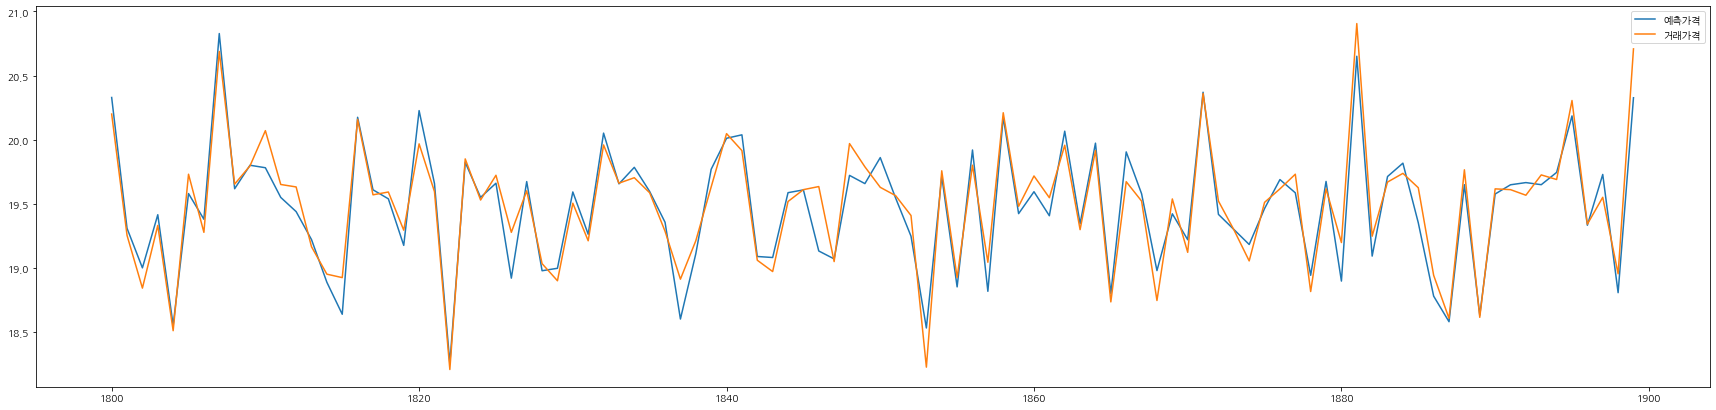

In [265]:
# 선형회귀분석 예측 정확도 시각화

plt.rc('font', family='NanumGothic')
table_li.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

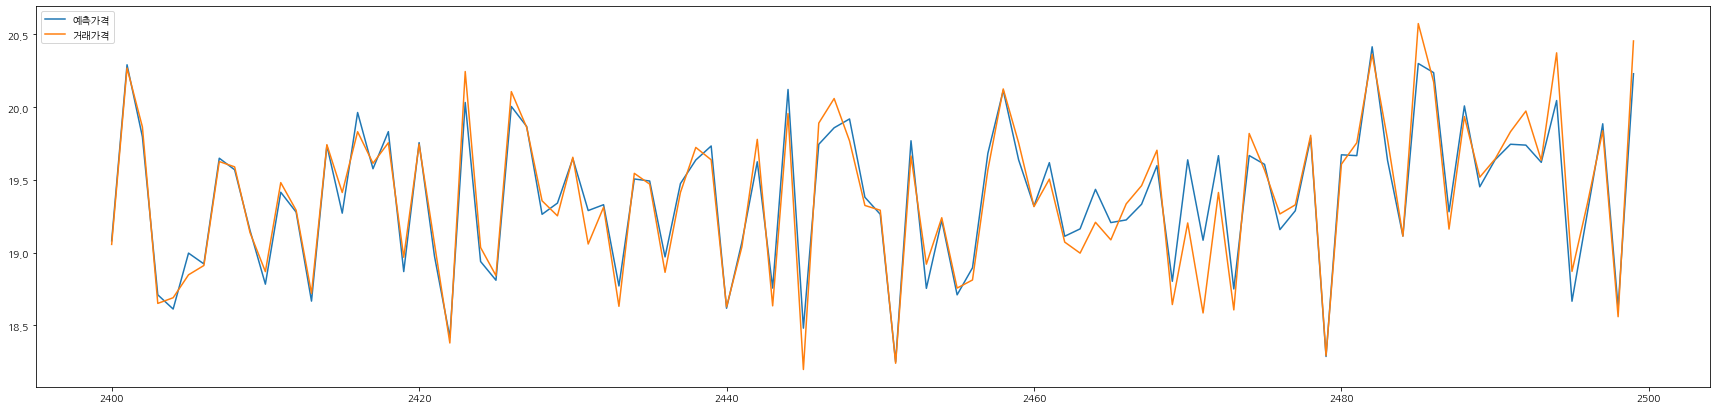

In [266]:
plt.rc('font', family='NanumGothic')
table_li.iloc[2400:2500, :].plot(figsize=(30,7))

<Axes: >

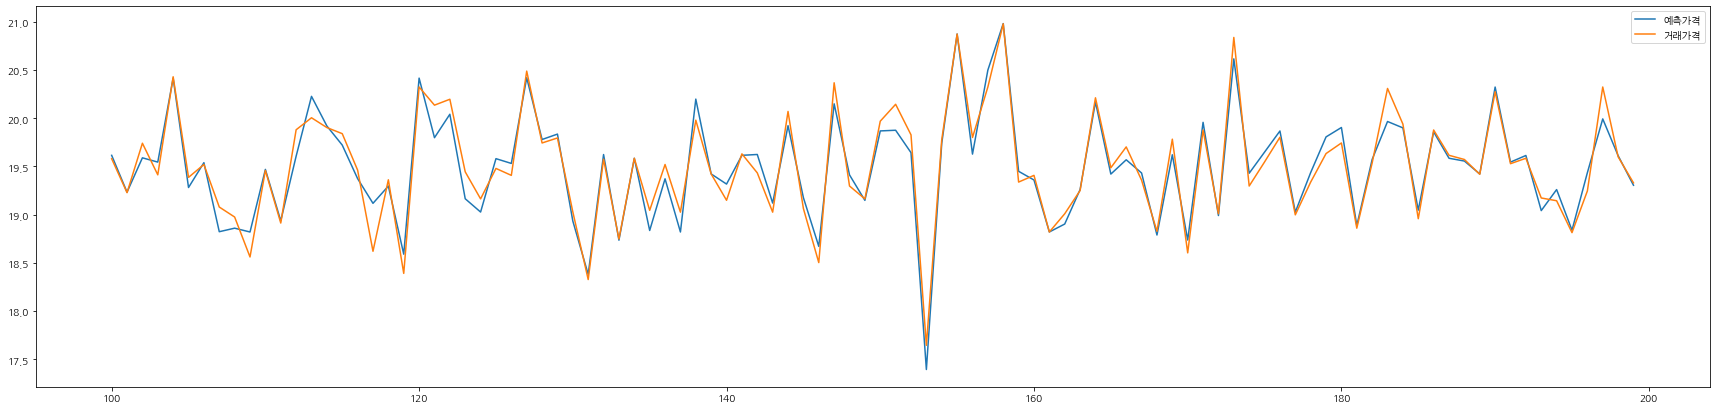

In [267]:
plt.rc('font', family='NanumGothic')
table_li.iloc[100:200, :].plot(figsize=(30,7))

In [268]:
error_li = table_li.copy()
error_li['오차율'] = (error_li['거래가격'] - error_li['예측가격']) / error_li['거래가격'] * 100
error_li['오차율'].describe()

count    47967.000000
mean        -0.035009
std          0.752482
min         -5.489153
25%         -0.435990
50%         -0.025422
75%          0.409555
max          6.284269
Name: 오차율, dtype: float64

,예측가격,거래가격,오차율,실제거래가격,실제예측가격
0,19.203619,19.143387,-0.314636,2.060000e+08,2.187891e+08
1,19.944465,20.038087,0.467220,5.040000e+08,4.589560e+08
2,20.176273,20.003775,-0.862331,4.870000e+08,5.786876e+08
3,19.428834,19.471502,0.219132,2.860000e+08,2.740535e+08
4,19.328168,19.287781,-0.209391,2.380000e+08,2.478088e+08
...,...,...,...,...,...
47962,19.238881,19.062535,-0.925096,1.900000e+08,2.266418e+08
47963,18.614829,18.459901,-0.839268,1.040000e+08,1.214277e+08
47964,19.339800,19.209138,-0.680205,2.200000e+08,2.507080e+08
47965,19.521947,19.413933,-0.556375,2.700000e+08,3.007972e+08


In [269]:
# 예측값과 실제값의 비교 - 의사결정나무

pred_tree = pd.DataFrame(final_pred_tree, columns=['예측가격'])
actual_tree = pd.DataFrame(y_test)
actual_tree.reset_index(inplace=True, drop=True)
table_tree = pd.concat([pred_tree, actual_tree], axis=1)

table_tree

,예측가격,거래가격
0,19.143387,19.143387
1,20.029555,20.038087
2,20.448829,20.003775
3,19.473239,19.471502
4,19.434017,19.287781
...,...,...
47962,19.295576,19.062535
47963,18.538223,18.459901
47964,19.217199,19.209138
47965,19.414841,19.413933


<Axes: >

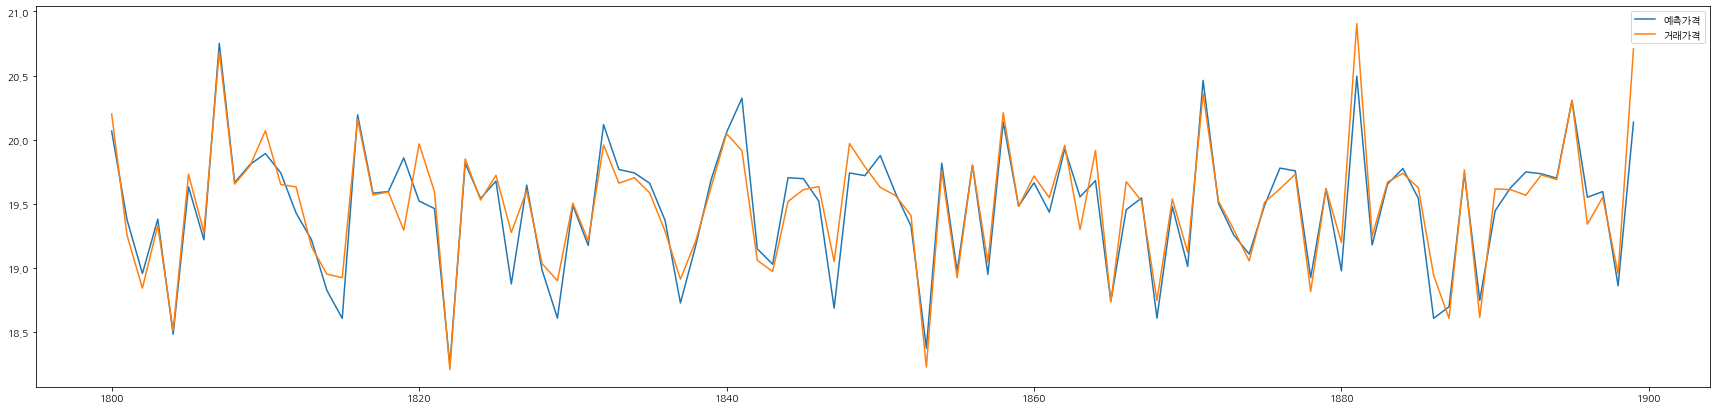

In [270]:
# 의사결정나무 예측 정확도 시각화

plt.rc('font', family='NanumGothic')
table_tree.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

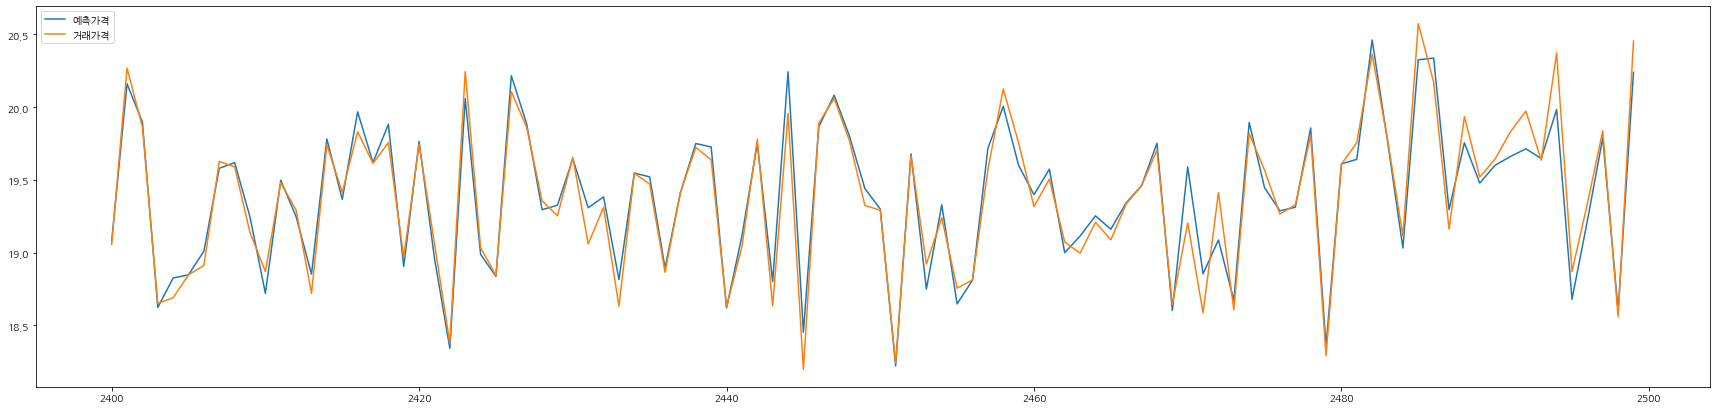

In [271]:
plt.rc('font', family='NanumGothic')
table_tree.iloc[2400:2500, :].plot(figsize=(30,7))

<Axes: >

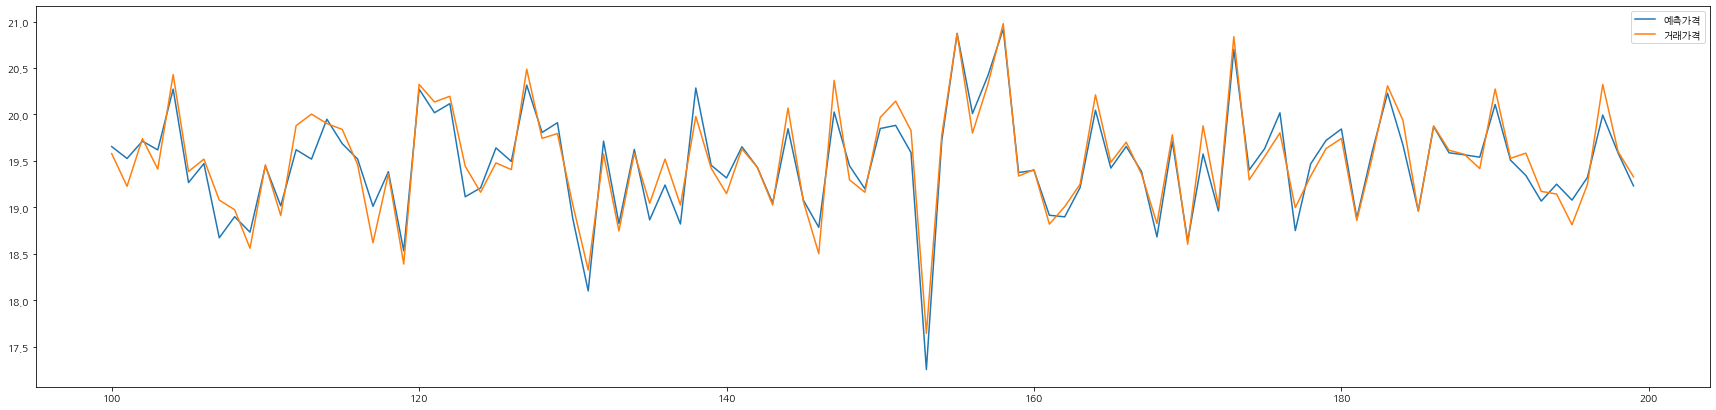

In [272]:
plt.rc('font', family='NanumGothic')
table_tree.iloc[100:200, :].plot(figsize=(30,7))

In [273]:
error_tree = table_tree.copy()
error_tree['오차율'] = (error_tree['거래가격'] - error_tree['예측가격']) / error_tree['거래가격'] * 100
error_tree['오차율'].describe()

count    47967.000000
mean         0.002658
std          0.863626
min         -7.363665
25%         -0.387540
50%         -0.028561
75%          0.364561
max          6.623753
Name: 오차율, dtype: float64

In [136]:
# 실거래가에 있는데 건물코드와 맵핑했더니 공시지가의 데이터 수가 약 4백만개 -> 2백만개 줄어듦

## 왜 나는 정확한 값이 안 나오지?? 왜 MAE랑 RMSE가 저렇게 작게 나오는 것이며, 다른 데에서는 다 달러 기준으로 나오는데 난 왜 20으로 단위가 줄어서 나오는 거지???

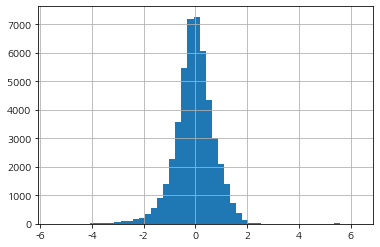

In [274]:
error_li['오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)

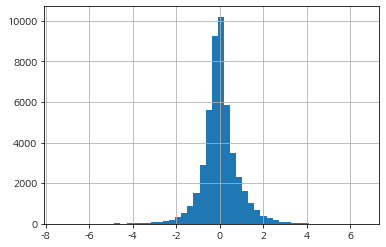

In [275]:
error_tree['오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)

In [286]:
error_li['실제거래가격'] = np.exp(error_li['거래가격'])
error_li['실제예측가격'] = np.exp(error_li['예측가격'])
error_li['실제오차율'] = (error_li['실제거래가격'] - error_li['실제예측가격']) / error_li['실제거래가격'] * 100
error_li

,예측가격,거래가격,오차율,실제거래가격,실제예측가격,실제오차율
0,19.203619,19.143387,-0.314636,2.060000e+08,2.187891e+08,-6.208291
1,19.944465,20.038087,0.467220,5.040000e+08,4.589560e+08,8.937297
2,20.176273,20.003775,-0.862331,4.870000e+08,5.786876e+08,-18.827025
3,19.428834,19.471502,0.219132,2.860000e+08,2.740535e+08,4.177081
4,19.328168,19.287781,-0.209391,2.380000e+08,2.478088e+08,-4.121354
...,...,...,...,...,...,...
47962,19.238881,19.062535,-0.925096,1.900000e+08,2.266418e+08,-19.285150
47963,18.614829,18.459901,-0.839268,1.040000e+08,1.214277e+08,-16.757392
47964,19.339800,19.209138,-0.680205,2.200000e+08,2.507080e+08,-13.958198
47965,19.521947,19.413933,-0.556375,2.700000e+08,3.007972e+08,-11.406356


In [287]:
error_li['실제오차율'].describe()

count    47967.000000
mean        -1.665314
std         15.378465
min       -147.688952
25%         -8.834291
50%         -0.492869
75%          7.671606
max         71.800572
Name: 실제오차율, dtype: float64

In [283]:
error_tree['실제거래가격'] = np.exp(error_tree['거래가격'])
error_tree['실제예측가격'] = np.exp(error_tree['예측가격'])
error_tree['실제오차율'] = (error_tree['실제거래가격'] - error_tree['실제예측가격']) / error_tree['실제거래가격'] * 100
error_tree

,예측가격,거래가격,오차율,실제거래가격,실제예측가격,실제오차율
0,19.143387,19.143387,0.000000,2.060000e+08,2.060000e+08,0.000000
1,20.029555,20.038087,0.042576,5.040000e+08,4.997185e+08,0.849506
2,20.448829,20.003775,-2.224852,4.870000e+08,7.600000e+08,-56.057495
3,19.473239,19.471502,-0.008921,2.860000e+08,2.864972e+08,-0.173862
4,19.434017,19.287781,-0.758181,2.380000e+08,2.754778e+08,-15.746961
...,...,...,...,...,...,...
47962,19.295576,19.062535,-1.222511,1.900000e+08,2.398625e+08,-26.243400
47963,18.538223,18.459901,-0.424280,1.040000e+08,1.124729e+08,-8.147038
47964,19.217199,19.209138,-0.041963,2.200000e+08,2.217805e+08,-0.809326
47965,19.414841,19.413933,-0.004681,2.700000e+08,2.702455e+08,-0.090922


In [284]:
error_tree['실제오차율'].describe()

count    47967.000000
mean        -1.333374
std         18.773151
min       -300.000000
25%         -7.812500
50%         -0.555100
75%          6.864352
max         73.664498
Name: 실제오차율, dtype: float64